<a href="https://colab.research.google.com/github/ArshT/Pytorch_Practice/blob/master/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [4]:
class VAE(nn.Module):

  def __init__(self):
    super(VAE, self).__init__()

    self.conv1 = nn.Conv2d(1,64,4,(2,2),(1,1))
    self.conv2 = nn.Conv2d(64,128,4,(2,2),(1,1))
    self.fc1 = nn.Linear(128*7*7,32)

    self.fc2 = nn.Linear(32,128*7*7)
    self.t_conv1 = nn.ConvTranspose2d(128,64,4,(2,2),(1,1))
    self.t_conv2 = nn.ConvTranspose2d(64,1,4,(2,2),(1,1))

  def reparametrize(self,mu,logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.empty_like(std).normal_()
    return eps.mul(std).add_(mu)
  
  def forward(self,x):
    
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(x.shape[0],128*7*7)

    mu = self.fc1(x)
    logvar = self.fc1(x)

    z = self.reparametrize(mu,logvar)
   
    x = F.relu(self.fc2(z))
    x = x.view(x.shape[0],128,7,7)
    x = F.relu(self.t_conv1(x))
    x = torch.sigmoid(self.t_conv2(x))
   

    return (x,mu,logvar)

vae = VAE()
vae = vae.to(device)
print(vae)

VAE(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=6272, bias=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv2): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [5]:
def vae_loss(recon_x,x,mu,logvar):

  bce_loss = F.binary_cross_entropy(recon_x.view(-1,784),x.view(-1,784),reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return KLD + bce_loss

In [6]:
optimizer = optim.Adam(vae.parameters(),0.001,weight_decay=1e-5)

In [7]:
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(100):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1,100, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 4903.835975
Epoch [2 / 100] average reconstruction error: 4322.108444
Epoch [3 / 100] average reconstruction error: 4218.130992
Epoch [4 / 100] average reconstruction error: 4164.251969
Epoch [5 / 100] average reconstruction error: 4122.308934
Epoch [6 / 100] average reconstruction error: 4089.147163
Epoch [7 / 100] average reconstruction error: 4070.100142
Epoch [8 / 100] average reconstruction error: 4050.471705
Epoch [9 / 100] average reconstruction error: 4032.561627
Epoch [10 / 100] average reconstruction error: 4018.934624
Epoch [11 / 100] average reconstruction error: 4006.992917
Epoch [12 / 100] average reconstruction error: 3994.020888
Epoch [13 / 100] average reconstruction error: 3987.137021
Epoch [14 / 100] average reconstruction error: 3980.314873
Epoch [15 / 100] average reconstruction error: 3971.168780
Epoch [16 / 100] average reconstruction error: 3968.575792
Epoch [17 / 100] average reconstruction error: 3960.

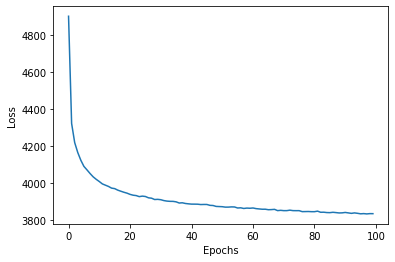

In [8]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [9]:
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 3827.643212


Original images


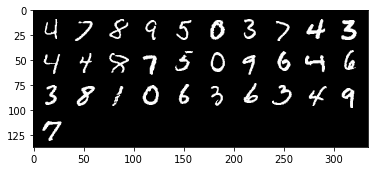

VAE reconstruction:


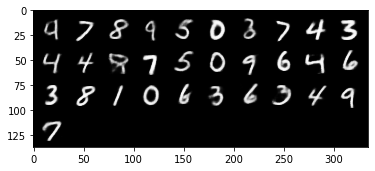

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()


def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()


print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

print('VAE reconstruction:')
visualise_output(images, vae)

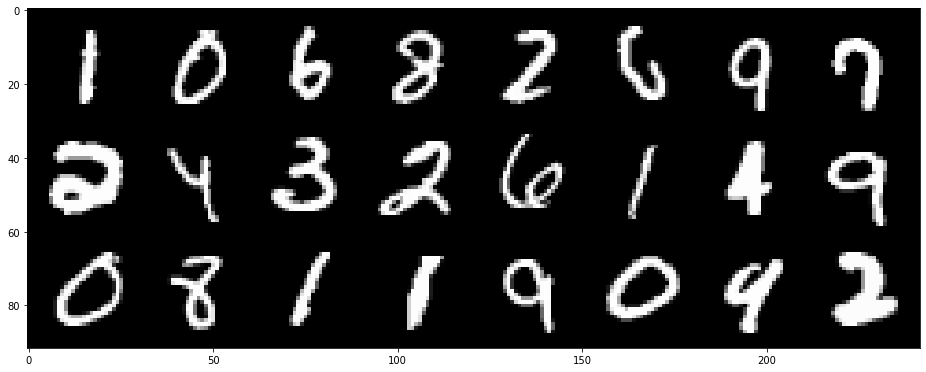

In [11]:
import numpy

samples, labels = iter(test_dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

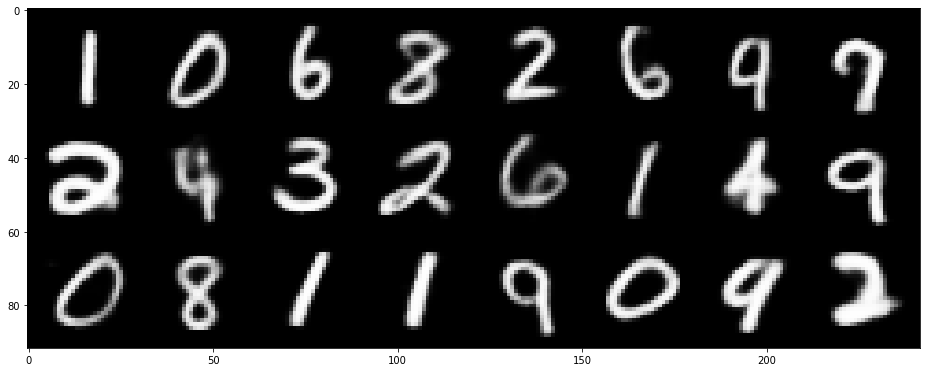

In [12]:
samples = samples.to(device='cuda', dtype=torch.float)
Results,_,_a = vae(samples)
Resluts = Results.to('cpu')
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(Results[:24])
grid_imgs = grid_imgs.to('cpu')
np_grid_imgs = grid_imgs.detach().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))